# Analysis of KNN models performances for artwork identification

## Artist classif

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data.experimental import cardinality
from tensorflow.data.experimental import AUTOTUNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
import matplotlib.colors as mcolors
color_list = mcolors.TABLEAU_COLORS

In [10]:
path_CNN_models = r'C:\Users\pitip\code\ClaireLeroux44\ArtRecognition\models\Full_training'
path_KNN_models = r'C:\Users\pitip\code\ClaireLeroux44\ArtRecognition\models\KNN_models\CNN_comparison'

In [11]:
#files = os.listdir(path_KNN_models)
#models_list = [os.path.splitext(f)[0].replace('KNN_model_', '') for f in files if f.find('.joblib')>0]
files = os.listdir(path_CNN_models)
models_list = [f for f in files if f.find('.')==-1]
models_list[:5]

['20201211_171053_VGG16_v3_1',
 '20201211_181927_VGG16_v3_2',
 '20201211_194603_VGG16_v3_3',
 '20201211_194616_VGG16_v4_1',
 '20201211_202203_VGG16_v3_4']

In [12]:
dict_recap = []
for model in models_list:
    history = pd.read_csv(os.path.join(path_CNN_models, model+'.csv'))
    with open(os.path.join(path_CNN_models, model+'.txt')) as f:
        lines = f.readlines()
    
    emb_size_str = [s for s in lines if 'Embedding size' in s]
    emb_size = int(emb_size_str[0].replace('Embedding size:', '').replace('\n', ''))
    
    data_aug_str = [s for s in lines if 'With data augmentation' in s]
    data_aug = (data_aug_str[0].replace('With data augmentation:', '').replace('\n', '').strip()) == 'True'
    
    layer_str = [s for s in lines if 'Last layer activation' in s]
    layer = layer_str[0].replace('Last layer activation:', '').replace('\n', '').strip()
    
    patience_str = [s for s in lines if 'patience number' in s]
    patience = int(patience_str[0].replace('patience number:', '').replace('\n', ''))
    
    loss_str = [s for s in lines if 'Loss on test set' in s]
    loss = float(loss_str[0].replace('Loss on test set:', '').replace('\n', ''))
    
    accuracy_str = [s for s in lines if 'Accuracy on test set' in s]
    accuracy = float(accuracy_str[0].replace('Accuracy on test set:', '').replace('\n', ''))
    
    dict_recap.append({'name': model, 'Embedding_size': emb_size, 'Data_augmentation': data_aug, 'Last_layer_activation': layer, 
                 'patience' :patience, 'Final_test_loss': loss, 'Final_test_accuracy': accuracy, 'History': history, 'Final epoch number': len(history)})
log_df = pd.DataFrame(dict_recap)
log_df = log_df.sort_values('Final_test_accuracy', ascending = False)
log_df.head()

,name,Embedding_size,Data_augmentation,Last_layer_activation,patience,Final_test_loss,Final_test_accuracy,History,Final epoch number
50,20201213_132004_VGG16_v4_19,200,False,sigmoid,50,0.5413,0.8331,loss accuracy val_loss val_accuracy...,72
38,20201212_205911_VGG16_v3_27,400,False,sigmoid,20,0.5387,0.8331,loss accuracy val_loss val_accuracy...,50
58,20201214_074739_VGG16_v4_27,400,False,sigmoid,50,0.5462,0.8309,loss accuracy val_loss val_accuracy...,87
35,20201212_193432_VGG16_v4_11,100,False,sigmoid,50,0.5794,0.8165,loss accuracy val_loss val_accuracy...,70
15,20201212_042057_VGG16_v3_11,100,False,sigmoid,20,0.5792,0.8151,loss accuracy val_loss val_accuracy...,49


In [13]:
act_fn = np.unique(log_df['Last_layer_activation'])
pat = [20, 50]
DA = [False, True]
plt_symbol = ['+-', 'o-']

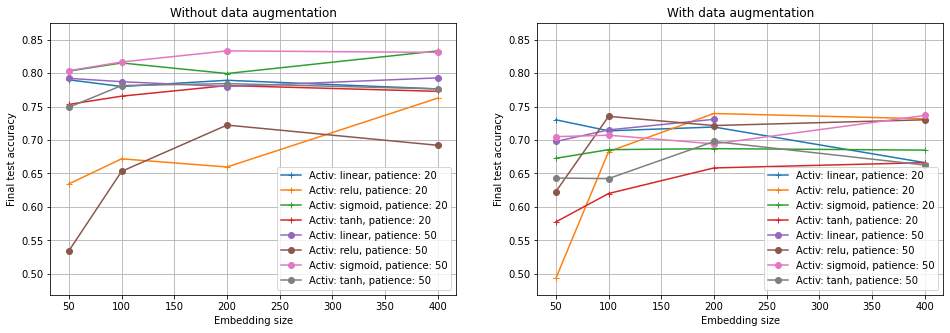

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
for i, ax in enumerate(axs):
    for j, p in enumerate(pat):
        for act in act_fn:
            sublog_df = log_df.loc[np.logical_and(log_df['patience']==p, log_df['Last_layer_activation']==act)]
            sublog_df2 = sublog_df.loc[sublog_df['Data_augmentation']==DA[i]]
            sublog_df2 = sublog_df2.sort_values('Embedding_size', ascending=True)
            ax.plot(sublog_df2['Embedding_size'], sublog_df2['Final_test_accuracy'], plt_symbol[j], label = f"Activ: {act}, patience: {p}")
    ax.legend()
    ax.set_xlabel('Embedding size')
    ax.set_ylabel('Final test accuracy')
axs[0].set_ylim([0.95*log_df['Final_test_accuracy'].min(), 1.05*log_df['Final_test_accuracy'].max()])
axs[1].set_ylim([0.95*log_df['Final_test_accuracy'].min(), 1.05*log_df['Final_test_accuracy'].max()])
axs[0].set_title('Without data augmentation')
axs[1].set_title('With data augmentation')
axs[0].grid()
axs[1].grid();
plt.savefig('figs/Artist_classif_accuracy_comparison.png')

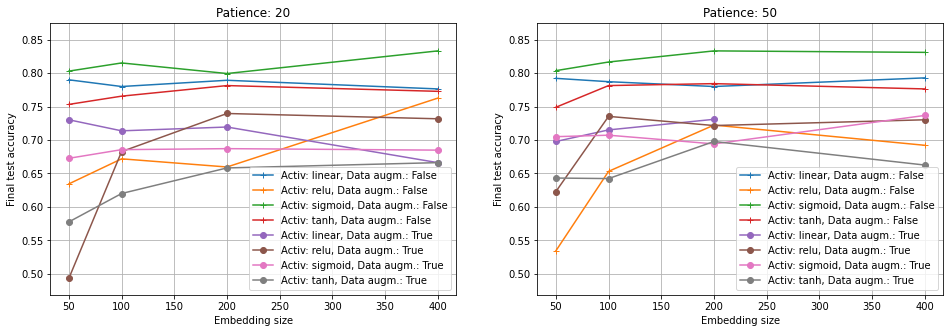

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
for i, ax in enumerate(axs):
    for j, da in enumerate(DA):
        for act in act_fn:
            sublog_df = log_df.loc[np.logical_and(log_df['patience']==pat[i], log_df['Last_layer_activation']==act)]
            sublog_df2 = sublog_df.loc[sublog_df['Data_augmentation']==da]
            sublog_df2 = sublog_df2.sort_values('Embedding_size', ascending=True)
            ax.plot(sublog_df2['Embedding_size'], sublog_df2['Final_test_accuracy'], plt_symbol[j], label = f"Activ: {act}, Data augm.: {da}")
    ax.legend()
    ax.set_xlabel('Embedding size')
    ax.set_ylabel('Final test accuracy')
axs[0].set_ylim([0.95*log_df['Final_test_accuracy'].min(), 1.05*log_df['Final_test_accuracy'].max()])
axs[1].set_ylim([0.95*log_df['Final_test_accuracy'].min(), 1.05*log_df['Final_test_accuracy'].max()])
axs[0].set_title('Patience: 20')
axs[1].set_title('Patience: 50')
axs[0].grid()
axs[1].grid();

## Artwork identification

In [16]:
models_list.append('Raw_VGG16_Top_12_test')
models_list.append('20201214_150118_VGG16_v4_31_Top_12')

In [17]:
dict2_recap = []
for model in models_list:
    if os.path.isfile(os.path.join(path_KNN_models, f"log_{model}.txt")):
        with open(os.path.join(path_KNN_models, f"log_{model}.txt")) as f:
            lines = f.readlines()
            
            acc_str = [s for s in lines if 'Total accuracy on test set' in s]
            acc = float(acc_str[0].replace('Total accuracy on test set:', '').replace('\n', ''))

            acc3_str = [s for s in lines if 'Total top 3 accuracy on test set' in s]
            acc3 = float(acc3_str[0].replace('Total top 3 accuracy on test set:', '').replace('\n', ''))

            transform_str = [s for s in lines if 'Transformation method' in s]
            ss1 = []
            ss3 = []
            for s in transform_str:
                ind_p = [m.start() for m in re.finditer(':', s)]
                ind_t = [m.start() for m in re.finditer('-', s)]
                ss1.append(float(s[ind_p[1]+1:ind_t[1]]))
                ss3.append(float(s[ind_p[2]+1:]))

            dict2_recap.append({'name': model, 'Total_accuracy': acc, 'Total_top3_accuracy': acc3, 
                               'Original_image_acc':ss1[0], 'Original_image_acc3':ss3[0], 
                               'Crop_image_acc':ss1[1], 'Crop_image_acc3':ss3[1], 
                                'Extend_image_acc':ss1[2], 'Extend_image_acc3':ss3[2], 
                                'Rotate_image_acc':ss1[3], 'Rotate_image_acc3':ss3[3], 
                                'Contrast_image_acc':ss1[4], 'Contrast_image_acc3':ss3[4], 
                                'Color_balance_image_acc':ss1[5], 'Color_balance_image_acc3':ss3[5], 
                                'Noise_image_acc':ss1[6], 'Noise_image_acc3':ss3[6],
                                'All_transform_image_acc':ss1[7], 'All_transform_image_acc3':ss3[7], 
                               })
log_id_df = pd.DataFrame(dict2_recap)
log_id_df = log_id_df.sort_values('Total_accuracy', ascending = False)
log_id_df = log_id_df.reset_index(drop=True)
log_id_df.head()

,name,Total_accuracy,Total_top3_accuracy,Original_image_acc,Original_image_acc3,Crop_image_acc,Crop_image_acc3,Extend_image_acc,Extend_image_acc3,Rotate_image_acc,Rotate_image_acc3,Contrast_image_acc,Contrast_image_acc3,Color_balance_image_acc,Color_balance_image_acc3,Noise_image_acc,Noise_image_acc3,All_transform_image_acc,All_transform_image_acc3
0,Raw_VGG16_Top_12_test,0.8307,0.8733,0.9684,0.9684,0.8526,0.8842,0.6632,0.7895,0.7895,0.8421,0.9579,0.9789,1.0,1.0,0.9579,0.9684,0.4444,0.5444
1,20201214_150118_VGG16_v4_31,0.7813,0.8387,0.9579,0.9579,0.7684,0.8316,0.6316,0.7579,0.6316,0.7579,0.9579,0.9579,1.0,1.0,0.9579,0.9579,0.3333,0.4778
2,20201213_010933_VGG16_v3_31,0.7787,0.8493,0.9474,0.9474,0.7053,0.8632,0.6211,0.7579,0.7053,0.7684,0.9474,0.9474,1.0,1.0,0.9474,0.9474,0.3444,0.5556
3,20201214_074739_VGG16_v4_27,0.7680,0.8200,0.9474,0.9579,0.7368,0.7895,0.5158,0.6842,0.7263,0.7895,0.9474,0.9579,1.0,1.0,0.9474,0.9579,0.3111,0.4111
4,20201212_205911_VGG16_v3_27,0.7387,0.8027,0.9474,0.9579,0.6632,0.7474,0.4632,0.5895,0.6211,0.7579,0.9474,0.9579,1.0,1.0,0.9474,0.9474,0.3111,0.4556


In [20]:
log_id_df.loc[log_id_df['name']=='20201214_150118_VGG16_v4_31_Top_12']

,name,Total_accuracy,Total_top3_accuracy,Original_image_acc,Original_image_acc3,Crop_image_acc,Crop_image_acc3,Extend_image_acc,Extend_image_acc3,Rotate_image_acc,Rotate_image_acc3,Contrast_image_acc,Contrast_image_acc3,Color_balance_image_acc,Color_balance_image_acc3,Noise_image_acc,Noise_image_acc3,All_transform_image_acc,All_transform_image_acc3
10,20201214_150118_VGG16_v4_31_Top_12,0.7027,0.7667,0.9263,0.9263,0.6211,0.7474,0.5263,0.6105,0.5368,0.6947,0.9158,0.9263,0.9778,0.9778,0.9053,0.9263,0.2,0.3111


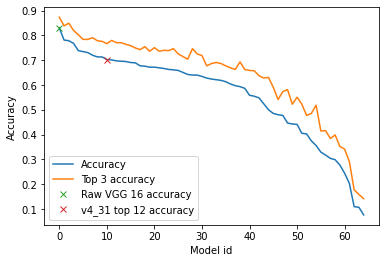

In [10]:
fig, ax = plt.subplots()
ax.plot(range(len(log_id_df)), log_id_df['Total_accuracy'], label ='Accuracy')
ax.plot(range(len(log_id_df)), log_id_df['Total_top3_accuracy'], label ='Top 3 accuracy')
ax.plot(log_id_df.loc[log_id_df['name']=='Raw_VGG16_Top_12_test', 'Total_accuracy'].index, log_id_df.loc[log_id_df['name']=='Raw_VGG16_Top_12_test', 
                                'Total_accuracy'], 'x', label ='Raw VGG 16 accuracy')
ax.plot(log_id_df.loc[log_id_df['name']=='20201214_150118_VGG16_v4_31_Top_12', 'Total_accuracy'].index, log_id_df.loc[log_id_df['name']=='20201214_150118_VGG16_v4_31_Top_12', 
                                'Total_accuracy'], 'x', label ='v4_31 top 12 accuracy')
ax.legend()
ax.set_xlabel('Model id')
ax.set_ylabel('Accuracy');

In [11]:
col_hex = []
for key in color_list:
    col_hex.append(color_list[key])

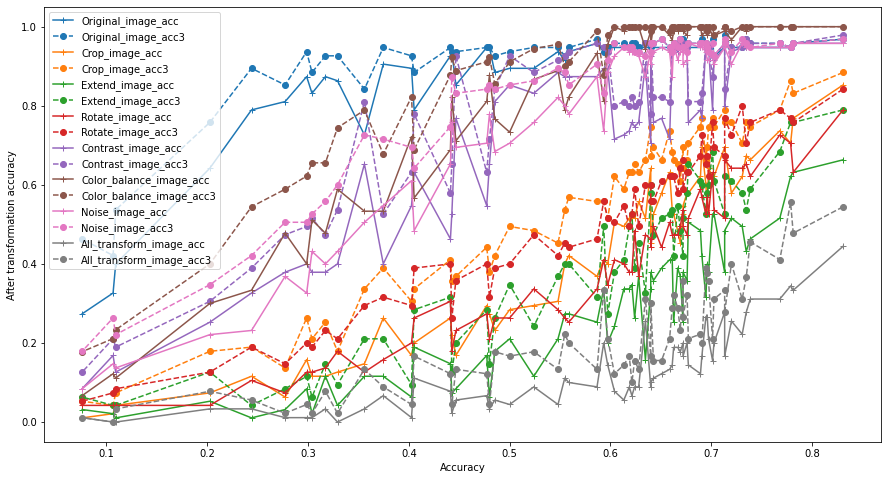

In [12]:
fig, ax = plt.subplots(figsize = (15, 8))
id_1 = 0
id_3 = 0
for col in log_id_df.columns:
    if col not in ['name', 'Total_accuracy', 'Total_top3_accuracy']:
        if col.find('3')==-1:
            fmt_str = '-+'
            col_code = col_hex[id_3]
            id_3 += 1
        else:
            fmt_str = '--o'
            col_code = col_hex[id_1]
            id_1 += 1
        ax.plot(log_id_df['Total_accuracy'], log_id_df[col], fmt_str, color = col_code, label = col)
ax.legend()
ax.set_xlabel('Accuracy')
ax.set_ylabel('After transformation accuracy');

# Comparison of both performances

In [13]:
merge_log_df = log_df.merge(log_id_df, on='name', how='outer')

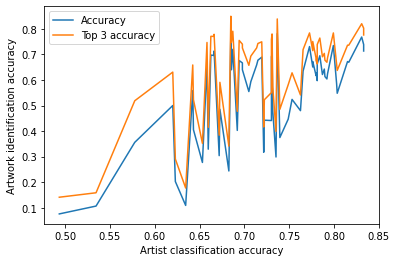

In [14]:
fig, ax = plt.subplots()
ax.plot(merge_log_df['Final_test_accuracy'], merge_log_df['Total_accuracy'], label ='Accuracy')
ax.plot(merge_log_df['Final_test_accuracy'], merge_log_df['Total_top3_accuracy'], label ='Top 3 accuracy')
ax.legend()
ax.set_xlabel('Artist classification accuracy')
ax.set_ylabel('Artwork identification accuracy');

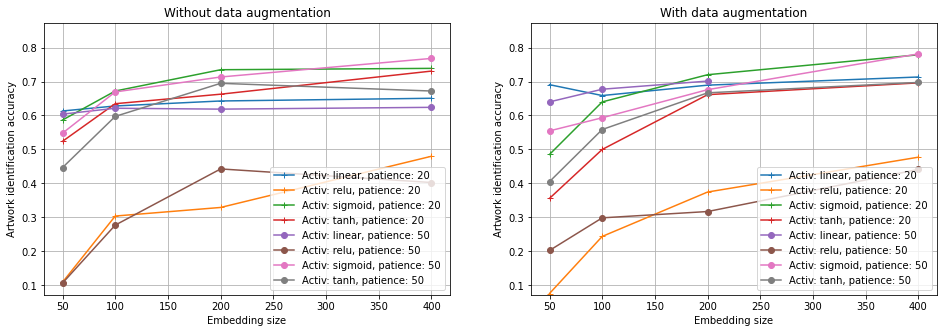

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
for i, ax in enumerate(axs):
    for j, p in enumerate(pat):
        for act in act_fn:
            sublog_df = merge_log_df.loc[np.logical_and(merge_log_df['patience']==p, merge_log_df['Last_layer_activation']==act)]
            sublog_df2 = sublog_df.loc[sublog_df['Data_augmentation']==DA[i]]
            sublog_df2 = sublog_df2.sort_values('Embedding_size', ascending=True)
            ax.plot(sublog_df2['Embedding_size'], sublog_df2['Total_accuracy'], plt_symbol[j], label = f"Activ: {act}, patience: {p}")
    ax.legend()
    ax.set_xlabel('Embedding size')
    ax.set_ylabel('Artwork identification accuracy')
axs[0].set_ylim([0.95*merge_log_df['Total_accuracy'].min(), 1.05*merge_log_df['Total_accuracy'].max()])
axs[1].set_ylim([0.95*merge_log_df['Total_accuracy'].min(), 1.05*merge_log_df['Total_accuracy'].max()])
axs[0].set_title('Without data augmentation')
axs[1].set_title('With data augmentation')
axs[0].grid()
axs[1].grid();

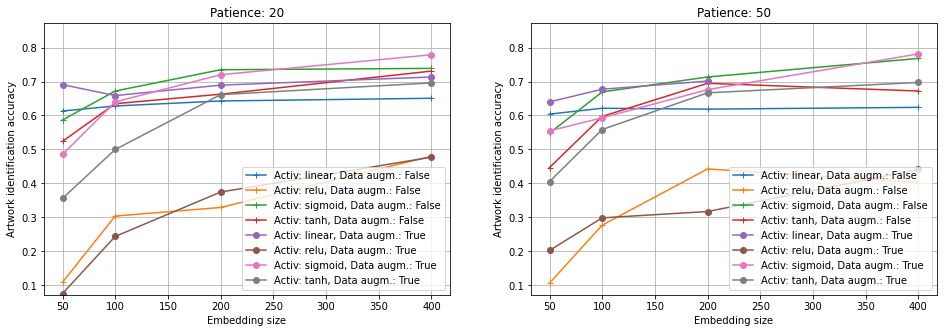

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
for i, ax in enumerate(axs):
    for j, da in enumerate(DA):
        for act in act_fn:
            sublog_df = merge_log_df.loc[np.logical_and(merge_log_df['patience']==pat[i], merge_log_df['Last_layer_activation']==act)]
            sublog_df2 = sublog_df.loc[sublog_df['Data_augmentation']==da]
            sublog_df2 = sublog_df2.sort_values('Embedding_size', ascending=True)
            ax.plot(sublog_df2['Embedding_size'], sublog_df2['Total_accuracy'], plt_symbol[j], label = f"Activ: {act}, Data augm.: {da}")
    ax.legend()
    ax.set_xlabel('Embedding size')
    ax.set_ylabel('Artwork identification accuracy')
axs[0].set_ylim([0.95*merge_log_df['Total_accuracy'].min(), 1.05*merge_log_df['Total_accuracy'].max()])
axs[1].set_ylim([0.95*merge_log_df['Total_accuracy'].min(), 1.05*merge_log_df['Total_accuracy'].max()])
axs[0].set_title('Patience: 20')
axs[1].set_title('Patience: 50')
axs[0].grid()
axs[1].grid();

In [17]:
col_list = ['name', 'Embedding_size', 'Data_augmentation', 'Last_layer_activation', 'patience', 
            'Final_test_loss', 'Final_test_accuracy', 'Final epoch number', 'Total_accuracy', 'Total_top3_accuracy']
merge_log_df.sort_values('Total_accuracy', ascending = False)[col_list].head()

,name,Embedding_size,Data_augmentation,Last_layer_activation,patience,Final_test_loss,Final_test_accuracy,Final epoch number,Total_accuracy,Total_top3_accuracy
63,Raw_VGG16_Top_12_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8307,0.8733
26,20201214_150118_VGG16_v4_31,400.0,True,sigmoid,50.0,0.8283,0.7367,108.0,0.7813,0.8387
45,20201213_010933_VGG16_v3_31,400.0,True,sigmoid,20.0,0.9432,0.6849,38.0,0.7787,0.8493
2,20201214_074739_VGG16_v4_27,400.0,False,sigmoid,50.0,0.5462,0.8309,87.0,0.7680,0.8200
1,20201212_205911_VGG16_v3_27,400.0,False,sigmoid,20.0,0.5387,0.8331,50.0,0.7387,0.8027
